In [1]:
import sys, glob, copy, argparse
from os import path
import yaml
import numpy as NP
import numpy.ma as MA
from astropy.io import ascii
from astropy.table import Table, Column
from astropy import units as U
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as PLT
from IPython.core.debugger import set_trace
%matplotlib inline

sys.path.append('../tableScripts')
import readParFile

## Read input file containing parameters for the script

In [2]:
parmsfile = '/fred/oz002/nthyagar/codes/mine/python/projects/dr2e/PSR_comparison/PSR_comparison_parms.yaml'
with open(parmsfile, 'r') as pfile:
    parms = yaml.safe_load(pfile)
    
projectdir = parms['dirstruct']['projectdir']
PTA_datadir = projectdir + parms['dirstruct']['PTA_data_dir']
outdir = projectdir + parms['dirstruct']['outdir']
figdir = outdir + parms['dirstruct']['figdir']
pta_dir_info = parms['dirstruct']['PTA_dirinfo']
print(parms)

{'dirstruct': {'projectdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/', 'PTA_data_dir': 'PTA_DataReleases/', 'outdir': 'outputs/', 'figdir': 'figures/', 'PTA_dirinfo': {'EPTA_DR1': {'PSRdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/PTA_DataReleases/eptaDR1/EPTA_v2.2_git/'}, 'NG_11yr': {'PSRdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/PTA_DataReleases/NANOGrav_11y/par/'}, 'NG_12.5yr_NB': {'PSRdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/PTA_DataReleases/NANOGrav_12yv3/narrowband/par/'}, 'NG_12.5yr_WB': {'PSRdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/PTA_DataReleases/NANOGrav_12yv3/wideband/par/'}, 'PPTA_DR1': {'PSRdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/PTA_DataReleases/ppta15/'}, 'PPTA_DR2': {'PSRdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/publish_collection/dr2/'}, 'PPTA_DR2E': {'PSRdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/publish_collection/dr2e/'}}}, 'compareParms': {'params': ['PX'], 'PTA': ['EPTA_DR1', 'NG_1

## Parse standard and specific (with variation) pulsar names in each PTA

In [3]:
pta_info = {}
for pta in pta_dir_info:
    pta_info[pta] = {'PSRdir': pta_dir_info[pta]['PSRdir']}
    if pta == 'EPTA_DR1':
        path_to_parfile_names = glob.glob(pta_dir_info[pta]['PSRdir']+'*')
        pta_info[pta]['PSRnames_simple'] = [fname_str.split('/')[-1] for fname_str in path_to_parfile_names]
        pta_info[pta]['PSRnames_specific'] = pta_info[pta]['PSRnames_simple']
    else:
        path_to_parfile_names = glob.glob(pta_dir_info[pta]['PSRdir']+'*.par')
        if 'PPTA' in pta:
            pta_info[pta]['PSRnames_simple'] = [fname_str.split('/')[-1].split('.')[0] for fname_str in path_to_parfile_names]
            pta_info[pta]['PSRnames_specific'] = [fname_str.split('/')[-1].split('.par')[0] for fname_str in path_to_parfile_names]
        else:
            pta_info[pta]['PSRnames_simple'] = [fname_str.split('/')[-1].split('_',1)[0] for fname_str in path_to_parfile_names]
            pta_info[pta]['PSRnames_specific'] = copy.deepcopy(pta_info[pta]['PSRnames_simple'])
            for ind,fname_str in enumerate(path_to_parfile_names):
                if fname_str.split('/')[-1].split('.')[-2] != 'gls':
                    append_str = fname_str.split('/')[-1].split('.')[-2]
                    pta_info[pta]['PSRnames_specific'][ind] = pta_info[pta]['PSRnames_simple'][ind] + '.' + append_str

## Create a sorted union of pulsar names

In [4]:
psrnames_simple_union = []
psrnames_specific_union = []
for pta in pta_dir_info:
    psrnames_simple_union += pta_info[pta]['PSRnames_simple']
    psrnames_specific_union += pta_info[pta]['PSRnames_specific']
psrnames_simple_union = NP.asarray(list(set(psrnames_simple_union)))
psrnames_specific_union = NP.asarray(list(set(psrnames_specific_union)))

## Sort these pulsars by RA/Dec

psrnames_simple_union = sorted(psrnames_simple_union, key=lambda x: ((int(x[1:5]), int(x[5:10])))) # Sort by RA-key and then by Dec-key
psrnames_specific_union = sorted(psrnames_specific_union, key=lambda x: ((x[1:5], x[5:10]))) # Sort by RA-key and then by Dec-key

print(psrnames_simple_union)
print(psrnames_specific_union)

['J0023+0923', 'J0030+0451', 'J0034-0534', 'J0218+4232', 'J0340+4130', 'J0437-4715', 'J0610-2100', 'J0613-0200', 'J0621+1002', 'J0636+5128', 'J0645+5158', 'J0711-6830', 'J0740+6620', 'J0751+1807', 'J0900-3144', 'J0931-1902', 'J1012+5307', 'J1017-7156', 'J1022+1001', 'J1024-0719', 'J1045-4509', 'J1125-6014', 'J1125+7819', 'J1446-4701', 'J1453+1902', 'J1455-3330', 'J1545-4550', 'J1600-3053', 'J1603-7202', 'J1614-2230', 'J1640+2224', 'J1643-1224', 'J1713+0747', 'J1721-2457', 'J1730-2304', 'J1732-5049', 'J1738+0333', 'J1741+1351', 'J1744-1134', 'J1747-4036', 'J1751-2857', 'J1801-1417', 'J1802-2124', 'J1804-2717', 'J1824-2452A', 'J1832-0836', 'J1843-1113', 'J1853+1303', 'B1855+09', 'J1857+0943', 'J1903+0327', 'J1909-3744', 'J1910+1256', 'J1911-1114', 'J1911+1347', 'J1918-0642', 'J1923+2515', 'B1937+21', 'J1939+2134', 'J1944+0907', 'J1946+3417', 'B1953+29', 'J1955+2908', 'J2010-1323', 'J2017+0603', 'J2019+2425', 'J2033+1734', 'J2043+1711', 'J2124-3358', 'J2129-5721', 'J2145-0750', 'J2214+300

## Populate the Numpy array with parameter values along with uncertainties from all PTA for all pulsars

In [5]:
compare_parms = parms['compareParms']
psr_parms = compare_parms['params']
ptas = NP.asarray(compare_parms['PTA'])
pta_psr_parm_vals = {parm: {} for parm in psr_parms}
pta_psr_parm_vals_normratio = {parm: {} for parm in psr_parms}
ref_pta = compare_parms['ref_PTA']
ref_pta_ind = ptas.tolist().index(ref_pta)
rest_pta_ind = NP.setdiff1d(NP.arange(ptas.size), ref_pta_ind)
rest_ptas = ptas[rest_pta_ind]

for parm in psr_parms:
    outvals = NP.empty((len(psrnames_simple_union),len(ptas),2), dtype=NP.float128)
    outvals.fill(NP.nan)
    for ptai,pta in enumerate(ptas):
        for psri,psr in enumerate(psrnames_simple_union):
            if psr in pta_info[pta]['PSRnames_simple']:
                if pta == 'EPTA_DR1':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}/{0}.par'.format(psr)
                elif pta == 'NG_11yr':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_NANOGrav_11yv1.gls.par'.format(psr)
                elif pta == 'NG_12.5yr_NB':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_NANOGrav_12yv3.gls.par'.format(psr)
                elif pta == 'NG_12.5yr_WB':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_NANOGrav_12yv3.wb.gls.par'.format(psr)
                elif pta == 'PPTA_DR1':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.par'.format(psr)
                elif (pta == 'PPTA_DR2') or (pta == 'PPTA_DR2E'):
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.par'.format(psr)
                    if not path.exists(parfilename):
                        parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.kop.par'.format(psr)
                    if not path.exists(parfilename):
                        parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.kop_alt.par'.format(psr)                    
                else:
                    raise ValueError('This PTA is either not requested in processing or unavailable in the database.')
                parmdict = readParFile.read_par(parfilename)
                if (parm in parmdict) and (parm+'_ERR' in parmdict):
                    pval = parmdict[parm]
                    pvalerr = parmdict[parm+'_ERR']
                    outvals[psri,ptai,:] = NP.asarray([pval, pvalerr], dtype=NP.float128)
        pta_psr_parm_vals[parm][pta] = MA.array(outvals[:,ptai,:], mask=NP.isnan(outvals[:,ptai,:]))
    pta_psr_parm_vals[parm]['all'] = MA.array(outvals, mask=NP.isnan(outvals))
    vals_normratio = NP.zeros((len(psrnames_simple_union),len(ptas),2), dtype=NP.float128)
    vals_normratio[:,:,0] = (outvals[:,:,0] - outvals[:,[ref_pta_ind],0]) / outvals[:,[ref_pta_ind],0]
    vals_normratio[:,:,1] = outvals[:,:,1] / outvals[:,[ref_pta_ind],1]
    pta_psr_parm_vals_normratio[parm]['all'] = MA.array(vals_normratio, mask=NP.isnan(vals_normratio))
    
    for psri,psr in enumerate(psrnames_simple_union):
        pta_psr_parm_vals[parm][psr] = MA.array(outvals[psri,:,:], mask=NP.isnan(outvals[psri,:,:]))
        pta_psr_parm_vals_normratio[parm][psr] = MA.array(vals_normratio[psri,:,:], mask=NP.isnan(vals_normratio[psri,:,:]))

In [6]:
print(pta_psr_parm_vals[parm]['all'])

[[[-- --]
  [0.93010000000000003784 0.15570000000000000506]
  [0.54779999999999995364 0.123700000000000004396]
  ...
  [-- --]
  [-- --]
  [-- --]]

 [[2.9118002610457711654 0.25009521605777729203]
  [3.079299999999999926 0.08379999999999999949]
  [3.08979999999999988 0.058900000000000000966]
  ...
  [-- --]
  [-- --]
  [-- --]]

 [[-- --]
  [-- --]
  [-- --]
  ...
  [-- --]
  [-- --]
  [-- --]]

 ...

 [[-- --]
  [0.55579999999999996074 1.017700000000000049]
  [0.44409999999999999476 0.83079999999999998295]
  ...
  [-- --]
  [-- --]
  [-- --]]

 [[-- --]
  [0.49490000000000000657 0.07839999999999999747]
  [0.6169999999999999929 0.07929999999999999549]
  ...
  [-- --]
  [-- --]
  [-- --]]

 [[-- --]
  [-- --]
  [0.97560000000000002274 0.25779999999999997362]
  ...
  [-- --]
  [-- --]
  [-- --]]]


In [7]:
print(pta_psr_parm_vals[parm]['J0023+0923'])
print('----------------------------------')
print(pta_psr_parm_vals[parm]['PPTA_DR2'])

[[-- --]
 [0.93010000000000003784 0.15570000000000000506]
 [0.54779999999999995364 0.123700000000000004396]
 [0.8294000000000000261 0.30390000000000000346]
 [-- --]
 [-- --]
 [-- --]]
----------------------------------
[[-- --]
 [-- --]
 [-- --]
 [-- --]
 [-- --]
 [-- --]
 [-- --]
 [0.9819403284602659099 0.08855325881481700134]
 [-- --]
 [-- --]
 [-- --]
 [-- --]
 [-- --]
 [-- --]
 [-- --]
 [-- --]
 [-- --]
 [1.2994564849362280068 0.68466421362377039017]
 [1.6458271025558075529 0.19159136082802938339]
 [0.8325178997531860192 0.13827396335109337633]
 [1.8531978141828353568 0.71670385762083488324]
 [2.1165448511867692716 0.41405625498645654003]
 [-- --]
 [0.6229222746982834291 0.36219492948223552808]
 [-- --]
 [-- --]
 [0.43291307403719686553 0.14139981319818384353]
 [0.5148044038344744555 0.05769162961849686605]
 [0.59484482712672637206 0.3841695919394861325]
 [-- --]
 [-- --]
 [0.8305728397239359184 0.16830310188866742793]
 [0.78524815976635164994 0.03321476928861877287]
 [-- --]
 [2.0

In [8]:
print(pta_psr_parm_vals_normratio[parm]['all'])

[[[-- --]
  [-- --]
  [-- --]
  ...
  [-- --]
  [-- --]
  [-- --]]

 [[-- --]
  [-- --]
  [-- --]
  ...
  [-- --]
  [-- --]
  [-- --]]

 [[-- --]
  [-- --]
  [-- --]
  ...
  [-- --]
  [-- --]
  [-- --]]

 ...

 [[-- --]
  [-- --]
  [-- --]
  ...
  [-- --]
  [-- --]
  [-- --]]

 [[-- --]
  [-- --]
  [-- --]
  ...
  [-- --]
  [-- --]
  [-- --]]

 [[-- --]
  [-- --]
  [-- --]
  ...
  [-- --]
  [-- --]
  [-- --]]]


## Plot: Fractional difference between various PTA estimates for each specified pulsar parameter

/fred/oz002/nthyagar/src/miniconda3/envs/PTA/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Saving figure at: /fred/oz002/nthyagar/projects/dr2_ephemerides/outputs/figures/PX_fracdiff.pdf


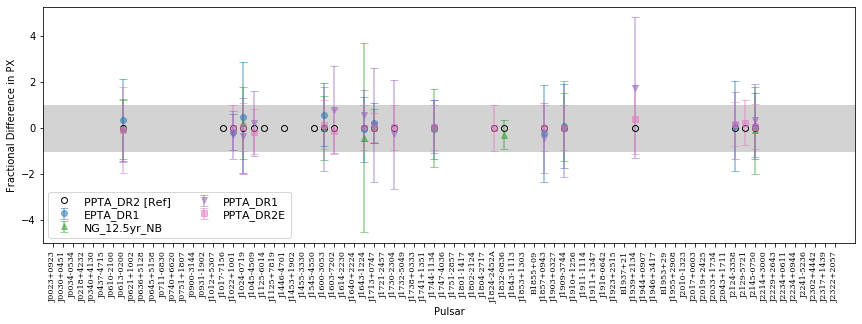

In [9]:
ptas_to_plot = compare_parms['plot_PTAs']
ind_ptas_to_plot = [ptas.tolist().index(pta_to_plot) for pta_to_plot in ptas_to_plot]
ptasymbols = ['o', 'd', '^', '*', 'v', '<', 's']
ptacolors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
for parm in psr_parms:
    fig = PLT.figure(figsize=(12,4.5))
    ax = fig.add_subplot(111)
    ax.fill_between(NP.asarray([-10,100]), -1, 1, color='lightgray')
    for ptai in ind_ptas_to_plot:
        if ptas[ptai] != ref_pta:
            ax.errorbar(NP.arange(len(psrnames_simple_union)), pta_psr_parm_vals_normratio[parm]['all'][:,ptai,0], yerr=pta_psr_parm_vals_normratio[parm]['all'][:,ptai,1], ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))
    ax.plot(NP.arange(len(psrnames_simple_union)), pta_psr_parm_vals_normratio[parm]['all'][:,ref_pta_ind,0], ls='none', marker='o', mfc='none', mec='black', mew=1, label=ref_pta+' [Ref]')
    ax.legend(loc='lower left', ncol=2, shadow=False, fontsize=11, labelspacing=0.2)
    ax.set_xlim(-1,len(psrnames_simple_union)+1)
    ax.set_xticks(NP.arange(len(psrnames_simple_union)))
    ax.set_xticklabels(psrnames_simple_union, rotation='vertical', fontdict={'fontsize': 8, 'ha': 'center', 'va': 'top', 'family': 'serif'})
    ax.set_xlabel('Pulsar')
    ax.set_ylabel('Fractional Difference in {0}'.format(parm))
    fig.subplots_adjust(left=0.05, right=0.99, bottom=0.25, top=0.98)
    
    PLT.savefig(figdir + '{0}_fracdiff.pdf'.format(parm), bbox_inches=0)
    print('Saving figure at: ' + figdir + '{0}_fracdiff.pdf'.format(parm))

## Make comparison dictionaries for requested parameters by creating an Astropy table for each

In [10]:
psrtables = {}
for parm in psr_parms:
    tabdict = {pta: pta_psr_parm_vals[parm][pta] for pta in ptas}
    psrtables[parm] = Table(copy.deepcopy(tabdict))
    psrtables[parm].add_column(Column(psrnames_simple_union, name='PSR'), index=0)

In [11]:
psrtables[parm].show_in_notebook(display_length=100)

idx,PSR,EPTA_DR1 [2],NG_11yr [2],NG_12.5yr_NB [2],NG_12.5yr_WB [2],PPTA_DR1 [2],PPTA_DR2 [2],PPTA_DR2E [2]
0,J0023+0923,-- .. --,0.93010000000000003784 .. 0.15570000000000000506,0.54779999999999995364 .. 0.123700000000000004396,0.8294000000000000261 .. 0.30390000000000000346,-- .. --,-- .. --,-- .. --
1,J0030+0451,2.9118002610457711654 .. 0.25009521605777729203,3.079299999999999926 .. 0.08379999999999999949,3.08979999999999988 .. 0.058900000000000000966,3.1356000000000001648 .. 0.06890000000000000291,-- .. --,-- .. --,-- .. --
2,J0034-0534,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --
3,J0218+4232,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --
4,J0340+4130,-- .. --,0.71389999999999997904 .. 0.4356999999999999762,0.6481999999999999984 .. 0.40560000000000001608,0.9980999999999999872 .. 0.3444999999999999729,-- .. --,-- .. --,-- .. --
5,J0437-4715,-- .. --,-- .. --,-- .. --,-- .. --,6.373334637440665418 .. 0.086288294189240555276,-- .. --,-- .. --
6,J0610-2100,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --
7,J0613-0200,1.3063152330513387867 .. 0.15786320035270848261,0.92920000000000002593 .. 0.19630000000000000226,0.90220000000000000195 .. 0.113299999999999997935,0.90690000000000003944 .. 0.11899999999999999467,0.85861986952944235885 .. 0.122772112656522616736,0.9819403284602659099 .. 0.08855325881481700134,0.8727005356907214795 .. 0.16411343272782108471
8,J0621+1002,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --
9,J0636+5128,-- .. --,0.88260000000000005116 .. 0.30140000000000000124,1.375199999999999978 .. 0.23460000000000000298,1.348200000000000065 .. 0.22759999999999999676,-- .. --,-- .. --,-- .. --
